In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install optuna

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

# Step 1: Load all time-sample rows per subject
input_folder = "/content/drive/MyDrive/ECEN 766 Final project/ML tests/processed_2Wavelenghts"
data_rows = []

for filename in sorted(os.listdir(input_folder)):

    if not filename.endswith(".csv"):
        continue
    filepath = os.path.join(input_folder, filename)
    df = pd.read_csv(filepath)

    subject_id = os.path.splitext(filename)[0]
    metadata = df.iloc[0][['Age', 'Height(cm)', 'Weight(kg)', 'Hemoglobin(g/L)', 'Gender', 'HR']]
    signal_df = df.dropna(subset=['660nm', '730nm', '850nm', '940nm'])

    for _, row in signal_df.iterrows():
        data_rows.append({
            "subject_id": subject_id,
            "660nm":    row["660nm"],
            "730nm":    row["730nm"],
            "850nm":    row["850nm"],
            "940nm":    row["940nm"],
            "Age":      metadata["Age"],
            "Height(cm)": metadata["Height(cm)"],
            "Weight(kg)": metadata["Weight(kg)"],
            "Gender":     metadata["Gender"],
            "HR":         metadata["HR"],
            "Hemoglobin": metadata["Hemoglobin(g/L)"]
        })

subject_df = pd.DataFrame(data_rows)

# Encode Gender
le = LabelEncoder()
subject_df["Gender"] = le.fit_transform(subject_df["Gender"])





[I 2025-05-05 15:45:26,876] A new study created in memory with name: no-name-d54f96b9-53c2-46ac-9e73-e4c03ccceb46
[I 2025-05-05 15:45:54,641] Trial 0 finished with value: 7.97318924453235 and parameters: {'max_depth': 5, 'eta': 0.24332479941499174, 'subsample': 0.880844397205907, 'colsample_bytree': 0.9056698775243271, 'lambda': 4.213947952843676, 'alpha': 3.7290068968630505, 'min_child_weight': 7}. Best is trial 0 with value: 7.97318924453235.
[I 2025-05-05 15:46:05,263] Trial 1 finished with value: 7.54829901280136 and parameters: {'max_depth': 5, 'eta': 0.14962006145430337, 'subsample': 0.9935794398803302, 'colsample_bytree': 0.8220616104125531, 'lambda': 4.0571966282747844, 'alpha': 3.1014860467103853, 'min_child_weight': 1}. Best is trial 1 with value: 7.54829901280136.
[I 2025-05-05 15:46:14,137] Trial 2 finished with value: 7.575976270461055 and parameters: {'max_depth': 6, 'eta': 0.15678382751868694, 'subsample': 0.9144891221127998, 'colsample_bytree': 0.683813255940432, 'lambd

Subject-level MAE: 6.86
Subject-level R²: 0.6905


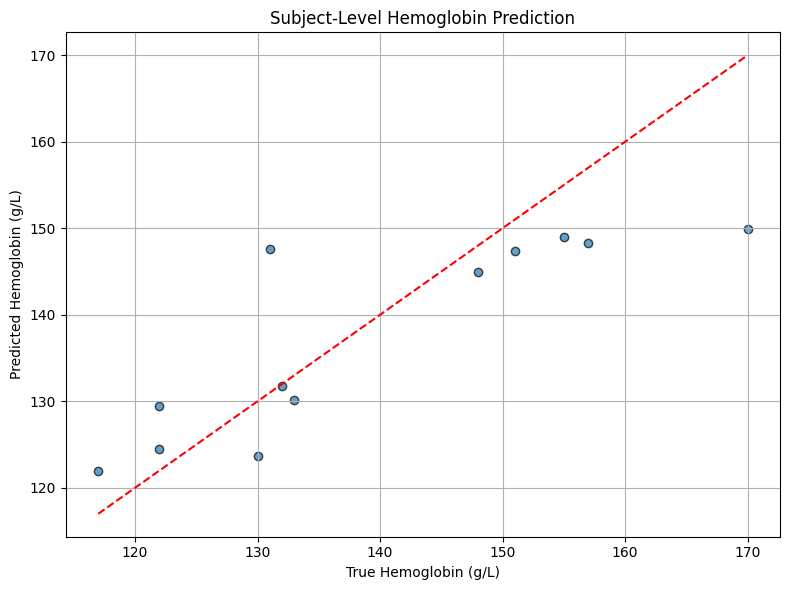

In [19]:


# Step 2: Split by subject_id
unique_ids = subject_df["subject_id"].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=41)

train_df = subject_df[subject_df["subject_id"].isin(train_ids)].reset_index(drop=True)
test_df = subject_df[subject_df["subject_id"].isin(test_ids)].reset_index(drop=True)

# Step 3: Prepare training inputs
X_train_raw = train_df.drop(columns=["Hemoglobin", "subject_id"])
y_train = train_df["Hemoglobin"]
groups_train = train_df["subject_id"]

# Step 4: Define Optuna objective with GroupKFold
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.1, 10.0),
        'alpha': trial.suggest_float('alpha', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'seed': 42,
    }

    gkf = GroupKFold(n_splits=5)
    fold_mae = []

    for train_idx, val_idx in gkf.split(X_train_raw, y_train, groups_train):
        X_tr, X_val = X_train_raw.iloc[train_idx], X_train_raw.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        dtrain = xgb.DMatrix(X_tr_scaled, label=y_tr)
        dval = xgb.DMatrix(X_val_scaled, label=y_val)

        model = xgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)
        preds = model.predict(dval)
        mae = mean_absolute_error(y_val, preds)
        fold_mae.append(mae)

    return np.mean(fold_mae)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Step 5: Train final model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)

final_model = xgb.train(study.best_params, dtrain, num_boost_round=100)

# Step 6: Evaluate on test set
X_test_raw = test_df.drop(columns=["Hemoglobin", "subject_id"])
y_test = test_df["Hemoglobin"]
X_test_scaled = scaler.transform(X_test_raw)
dtest = xgb.DMatrix(X_test_scaled)
y_pred = final_model.predict(dtest)

test_df = test_df.copy()
test_df["predicted"] = y_pred

# Step 7: Aggregate predictions per subject
subject_level = test_df.groupby("subject_id").agg(
    true_hb=("Hemoglobin", "first"),
    predicted_hb=("predicted", "mean")
).reset_index()

# Evaluation
mae = mean_absolute_error(subject_level["true_hb"], subject_level["predicted_hb"])
r2 = r2_score(subject_level["true_hb"], subject_level["predicted_hb"])
print(f"Subject-level MAE: {mae:.2f}")
print(f"Subject-level R²: {r2:.4f}")

# Step 8: Plot
plt.figure(figsize=(8, 6))
plt.scatter(subject_level["true_hb"], subject_level["predicted_hb"], alpha=0.7, edgecolors='k')
plt.plot([subject_level["true_hb"].min(), subject_level["true_hb"].max()],
         [subject_level["true_hb"].min(), subject_level["true_hb"].max()], 'r--')
plt.xlabel("True Hemoglobin (g/L)")
plt.ylabel("Predicted Hemoglobin (g/L)")
plt.title("Subject-Level Hemoglobin Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Save XGBoost model to disk
final_model.save_model("/content/drive/MyDrive/ECEN 766 Final project/ML tests/xgboost_model.json")
print(" XGBoost model saved as xgboost_model.json")

 XGBoost model saved as xgboost_model.json


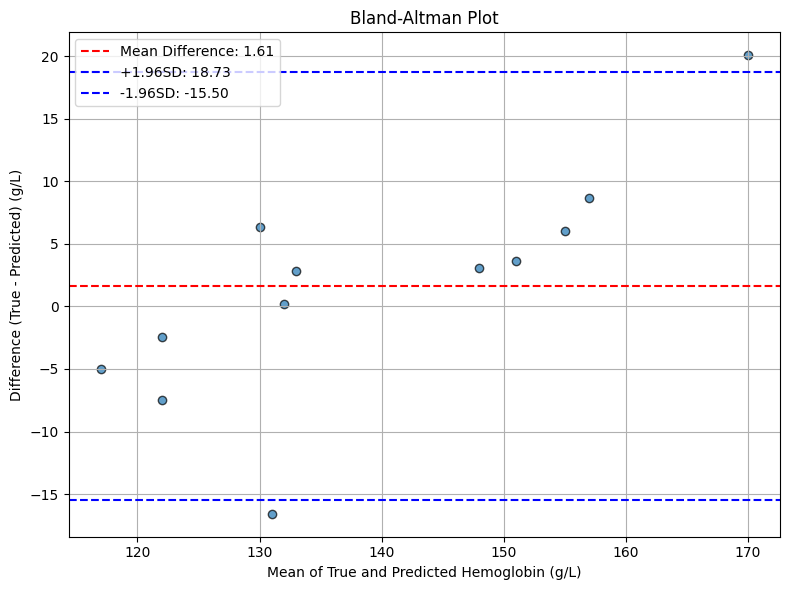

In [23]:
import matplotlib.pyplot as plt

# Calculate the difference between true and predicted values
difference = subject_level["true_hb"] - subject_level["predicted_hb"]

# Calculate the mean of the differences
mean_diff = np.mean(difference)

# Calculate the standard deviation of the differences
std_diff = np.std(difference)

# Create the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(subject_level["true_hb"], difference, alpha=0.7, edgecolors='k')
plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Difference: {mean_diff:.2f}")
plt.axhline(mean_diff + 1.96 * std_diff, color='blue', linestyle='--', label=f"+1.96SD: {mean_diff + 1.96 * std_diff:.2f}")
plt.axhline(mean_diff - 1.96 * std_diff, color='blue', linestyle='--', label=f"-1.96SD: {mean_diff - 1.96 * std_diff:.2f}")
plt.xlabel("Mean of True and Predicted Hemoglobin (g/L)")
plt.ylabel("Difference (True - Predicted) (g/L)")
plt.title("Bland-Altman Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
